# europe.csv

# Data parsing

In [1]:
using PyPlot: pygui
pygui(true)
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
include("import_all.jl")

write_solution_to_file (generic function with 1 method)

## Reading the instance

In [44]:
function read_instance(instance_file)
    data = open(joinpath("..", "sujet", instance_file)) do file
        readlines(file)
    end

    dims = lire_dimensions(data[1])

    emballages = [lire_emballage(data[1+e], dims) for e = 1:dims.E]

    usines = [lire_usine(data[1+dims.E+u], dims) for u = 1:dims.U]

    fournisseurs = [
        lire_fournisseur(data[1+dims.E+dims.U+f], dims) for f = 1:dims.F
    ]

    graphe = lire_graphe(data[1+dims.E+dims.U+dims.F+1:end], dims)

    instance = lire_instance(joinpath("..", "sujet", instance_file))

#     plot_sites(instance)
    return dims, emballages, usines,fournisseurs,graphe, instance
end

read_instance (generic function with 1 method)

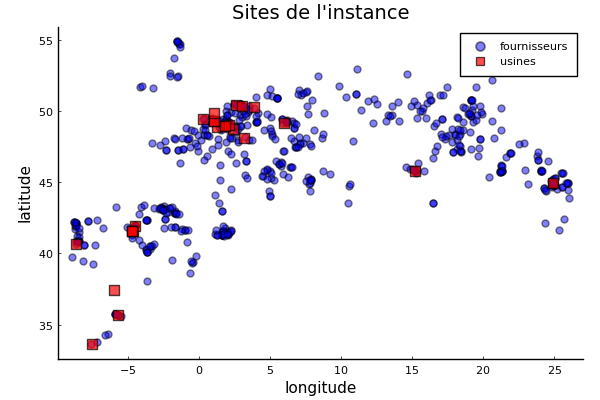

In [10]:
plot_sites(instance)

# Solution

# PLNE to find the number of packaging sent from each u to f

In [17]:
using JuMP
using Gurobi
import LightGraphs
const lg = LightGraphs

LightGraphs

## Func def

In [18]:
function create_graph(G_original, dims, us, fs, es, J_init, J_fin, e)
    U = dims.U
    F = dims.F
    J = J_fin - J_init + 1
    # J = dims.J
    cost_dispatch = dims.γ
    L = dims.L
    
    G = SimpleDiGraph((3 * U + 4 * F) * J + U + F + 1)
    capacity = zeros((3 * U + 4 * F) * J + U + F + 1, 
        (3 * U + 4 * F) * J + U + F + 1)
    cost_mat = zeros((3 * U + 4 * F) * J + U + F + 1, 
        (3 * U + 4 * F) * J + U + F + 1)
    
    for j = 1:J # for each day
        for u = 1:U # connect each u to each f stock
            for f = 1:F
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                    (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1)
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                    (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += Inf
                cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                    (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += (G_original.d[u, U + f] * cost_dispatch + dims.ccam + dims.cstop) / L * es[e].l
            end
        end
        
        for f = 1:F
            # connect fictive u (carton) to each f consommation
            add_edge!(G, nv(G), (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f)
            #add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f, nv(G)) # cycle
            capacity[nv(G), (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f] += Inf
            #capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f, nv(G)] += Inf
            cost_mat[nv(G), (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f] += fs[f].cexc[e]
            # cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f, nv(G)] += fs[f].cexc[e]
        end
    end
    
    for j = 1:J
        for u = 1:U
            # connect u day j to two additional vertices
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2)
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3)
            
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2] += us[u].r[e, j + J_init - 1]
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3] += Inf
            
            cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3] += us[u].cs[e]
            
            if j < J
                # connect two additional vertices to u day j+1
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1)
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1)
                
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1] += us[u].r[e, j + J_init - 1]
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1] += Inf
            end
        end
        
        for f = 1:F
            # connect f stock day j to two additional vertices
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2)
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3)
            
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2] += fs[f].r[e, j + J_init - 1]
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3] += Inf
            
            cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3] += fs[f].cs[e]
            
            if j < J
                # connect each f stock to f consommation of the next day
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, j * (3 * U + 4 * F) + 3 * U + 4 * f)
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, j * (3 * U + 4 * F) + 3 * U + 4 * f] += Inf
                
                # connect two additional vertices to f day j+1
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1)
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1)
                
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += fs[f].r[e, j + J_init - 1]
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += Inf
            end
        end
    end
    
    # connect initial stock to the stock of day 1 (for each u)
    for u = 1:U
        add_edge!(G, (3 * U + 4 * F) * J + u, 3 * (u - 1) + 1)
        
        capacity[(3 * U + 4 * F) * J + u, 3 * (u - 1) + 1] += Inf
    end
    
    # connect initial stock to the stock of day 1 (for each f) & to the f consommation of day 1
    for f = 1:F
        add_edge!(G, (3 * U + 4 * F) * J + U + f, 3 * U + 4 * (f - 1) + 1)  
        add_edge!(G, (3 * U + 4 * F) * J + U + f, 3 * U + 4 * f)
        
        capacity[(3 * U + 4 * F) * J + U + f, 3 * U + 4 * (f - 1) + 1] += Inf
        capacity[(3 * U + 4 * F) * J + U + f, 3 * U + 4 * f] += Inf
    end
    
    return G, capacity, cost_mat
end

create_graph (generic function with 1 method)

In [105]:
function create_graph_only(dims, J_init, J_fin)
    U = dims.U
    F = dims.F
    J = J_fin - J_init + 1
    # J = dims.J
    L = dims.L
    
    G = SimpleDiGraph((3 * U + 4 * F) * J + U + F + 1)
    
    for j = 1:J # for each day
        for u = 1:U # connect each u to each f stock
            for f = 1:F
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                    (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1)
            end
        end
        
        for f = 1:F
            # connect fictive u (carton) to each f consommation
            add_edge!(G, nv(G), (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f)
        end
    end
    
    for j = 1:J
        for u = 1:U
            # connect u day j to two additional vertices
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2)
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3)
            
            if j < J
                # connect two additional vertices to u day j+1
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1)
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1)
            end
        end
        
        for f = 1:F
            # connect f stock day j to two additional vertices
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2)
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3)
            
            if j < J
                # connect each f stock to f consommation of the next day
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, j * (3 * U + 4 * F) + 3 * U + 4 * f)
                
                # connect two additional vertices to f day j+1
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1)
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1)
            end
        end
    end
    
    # connect initial stock to the stock of day 1 (for each u)
    for u = 1:U
        add_edge!(G, (3 * U + 4 * F) * J + u, 3 * (u - 1) + 1)
    end
    
    # connect initial stock to the stock of day 1 (for each f) & to the f consommation of day 1
    for f = 1:F
        add_edge!(G, (3 * U + 4 * F) * J + U + f, 3 * U + 4 * (f - 1) + 1)  
        add_edge!(G, (3 * U + 4 * F) * J + U + f, 3 * U + 4 * f)
    end
    
    return G
end

create_graph_only (generic function with 1 method)

In [106]:
function create_cap_cost(G_original, dims, us, fs, es, J_init, J_fin, e)
    U = dims.U
    F = dims.F
    J = J_fin - J_init + 1
    # J = dims.J
    cost_dispatch = dims.γ
    L = dims.L
    tot = (3 * U + 4 * F) * J + U + F + 1
    
    capacity = zeros((3 * U + 4 * F) * J + U + F + 1, 
        (3 * U + 4 * F) * J + U + F + 1)
    cost_mat = zeros((3 * U + 4 * F) * J + U + F + 1, 
        (3 * U + 4 * F) * J + U + F + 1)
    
    for j = 1:J # for each day
        for u = 1:U # connect each u to each f stock
            for f = 1:F
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                    (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += Inf
                cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                    (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += (G_original.d[u, U + f] * cost_dispatch + dims.ccam + dims.cstop) / L * es[e].l
            end
        end
        
        for f = 1:F
            # connect fictive u (carton) to each f consommation
            capacity[tot, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f] += Inf
            #capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f, nv(G)] += Inf
            cost_mat[tot, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f] += fs[f].cexc[e]
            # cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f, nv(G)] += fs[f].cexc[e]
        end
    end
    
    for j = 1:J
        for u = 1:U
            # connect u day j to two additional vertices
            
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2] += us[u].r[e, j + J_init - 1]
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3] += Inf
            
            cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3] += us[u].cs[e]
            
            if j < J
                # connect two additional vertices to u day j+1
                
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1] += us[u].r[e, j + J_init - 1]
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1] += Inf
            end
        end
        
        for f = 1:F
            # connect f stock day j to two additional vertices
            
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2] += fs[f].r[e, j + J_init - 1]
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3] += Inf
            
            cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3] += fs[f].cs[e]
            
            if j < J
                # connect each f stock to f consommation of the next day
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, j * (3 * U + 4 * F) + 3 * U + 4 * f] += Inf
                
                # connect two additional vertices to f day j+1
                
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += fs[f].r[e, j + J_init - 1]
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += Inf
            end
        end
    end
    
    # connect initial stock to the stock of day 1 (for each u)
    for u = 1:U        
        capacity[(3 * U + 4 * F) * J + u, 3 * (u - 1) + 1] += Inf
    end
    
    # connect initial stock to the stock of day 1 (for each f) & to the f consommation of day 1
    for f = 1:F
        capacity[(3 * U + 4 * F) * J + U + f, 3 * U + 4 * (f - 1) + 1] += Inf
        capacity[(3 * U + 4 * F) * J + U + f, 3 * U + 4 * f] += Inf
    end
    
    return capacity, cost_mat
end

create_cap_cost (generic function with 1 method)

In [107]:
# for a given e
function set_demand(dims, us, fs, J_init, J_fin, e) # b parameter
    U = dims.U
    F = dims.F
    J = J_fin - J_init + 1
    # J = dims.J
    demand = zeros((3 * U + 4 * F) * J + U + F + 1)
    
    for j = 1:J
        # for each u
        for u = 1:U
            demand[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1] -= us[u].b⁺[e, j + J_init - 1]
        end
        
        # for each f consommation
        for f = 1:F
            demand[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f] += fs[f].b⁻[e, j + J_init - 1]
        end
    end
    
    # for initial stock
    if J_init == 1
        for u = 1:U
            demand[J * (3 * U + 4 * F) + u] -= us[u].s0[e]
        end
    
        for f = 1:F
            demand[J * (3 * U + 4 * F) + U + f] -= fs[f].s0[e]
        end
    else
        for u = 1:U
            demand[J * (3 * U + 4 * F) + u] -= us[u].s[e, J_init - 1]
        end
        
        for f = 1:F
            demand[J * (3 * U + 4 * F) + U + f] -= fs[f].s[e, J_init - 1]
        end
    end
    
    println(sum(demand))
    # additional vertices from day 1 to day J-1: b = 0
    # additional vertices of day J: b >= 0
    demand[(3 * U + 4 * F) * J + U + F + 1] += Inf # +Inf means that b is not fixed
    for u = 1:U
        demand[(J - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2] -= Inf # -Inf means b>=0
        demand[(J - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3] -= Inf
    end
    for f = 1:F
        demand[(J - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2] -= Inf
        demand[(J - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3] -= Inf
    end
    
    return demand
end

set_demand (generic function with 1 method)

In [108]:
function min_cost_flow(g, node_demand, edge_capacity, edge_cost, optimizer)
    m = JuMP.Model(optimizer)
    vtxs = vertices(g)
    
    source_nodes = [v for v in vtxs if node_demand[v] < 0 && node_demand[v] != -Inf]
    sink_nodes = [v for v in vtxs if node_demand[v] > 0 && node_demand[v] != Inf]
    
    idx_dict = Dict()
    ridx_dict = Dict()
    i = 1
    for e in lg.edges(g)
        idx_dict[i] = [src(e), dst(e)]
        ridx_dict[(src(e), dst(e))] = i
        i += 1
    end
    
    @variable(m, 0 <= f[i = 1:ne(g)] <= edge_capacity[idx_dict[i][1], idx_dict[i][2]], Int)
    @objective(m, Min, sum(f[i] * edge_cost[idx_dict[i][1], idx_dict[i][2]] for i = 1:ne(g)))
    # @variable(m, 0 <= f[i=vtxs, j=vtxs; (i,j) in lg.edges(g)] <= edge_capacity[i, j])
    # @objective(m, Min, sum(f[src(e),dst(e)] * edge_cost[src(e), dst(e)] for e in lg.edges(g)))

    for v in lg.vertices(g)
        if v in source_nodes
            @constraint(m,
                sum(f[ridx_dict[(v, vout)]] for vout in outneighbors(g, v)) - sum(f[ridx_dict[(vin, v)]] for vin in lg.inneighbors(g, v)) == -node_demand[v]
            )
        elseif v in sink_nodes
            @constraint(m,
                sum(f[ridx_dict[(vin, v)]] for vin in lg.inneighbors(g, v)) - sum(f[ridx_dict[(v, vout)]] for vout in outneighbors(g, v)) == node_demand[v]
            )
        else
            if node_demand[v] == -Inf
                @constraint(m, sum(f[ridx_dict[(vin, v)]] for vin in lg.inneighbors(g, v)) - sum(f[ridx_dict[(v, vout)]] for vout in outneighbors(g, v)) >= 0)
            elseif node_demand[v] != Inf
                @constraint(m,
                    sum(f[ridx_dict[(vin, v)]] for vin in lg.inneighbors(g, v)) == sum(f[ridx_dict[(v, vout)]] for vout in outneighbors(g, v))
                )
            end
        end
    end

    optimize!(m)
    ts = termination_status(m)
    result_flow = spzeros(nv(g), nv(g))
    if ts != MOI.OPTIMAL
        @warn "Problem does not have an optimal solution, status: $(ts)"
        return result_flow
    end
    for e in lg.edges(g)
        (i,j) = Tuple(e)
        result_flow[i,j] = JuMP.value(f[ridx_dict[(i,j)]])
    end
    return result_flow
    
end

min_cost_flow (generic function with 1 method)

In [109]:
function run_opt(g_original, g, dims, us, fs, es, J_init, J_fin, e, optimizer)
    capacity, cost_mat = create_cap_cost(g_original, dims, us, fs, es, J_init, J_fin, e)
    #g, capacity, cost_mat = create_graph(g, dims, us, fs, es, J_init, J_fin, e)
    demand = set_demand(dims, us, fs, J_init, J_fin, e)
    flow = min_cost_flow(g, demand, capacity, cost_mat, optimizer)
    return flow
end

run_opt (generic function with 2 methods)

In [22]:
function read_flow(flow, U, F, J_init, J_fin)
    # create a U * F * J matrix (for a given e) for dispatching
    # create a U * J matrix (for a given e) for stockage
    # create a F * J matrix (for a given e) for stockage
    # create a F * J matrix (for a given e) for carton consommation
    J = J_fin - J_init + 1
    dispatch = zeros(U, F, J)
    stock_U = zeros(U, J)
    stock_F = zeros(F, J)
    consom_carton = zeros(F, J)
    for j = 1:J
        for u = 1:U
            for f = 1:F
                dispatch[u, f, j] += flow[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1,
                    (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1]
            end
        end
        
        for u = 1:U
            stock_U[u, j] = flow[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2] +
            flow[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3]
        end
        
        for f = 1:F
            stock_F[f, j] = flow[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1,
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2] + 
            flow[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1,
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3]
            
            consom_carton[f, j] = flow[size(flow)[1], (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f]
        end
    end
    
    return dispatch, consom_carton, stock_U, stock_F
end

read_flow (generic function with 1 method)

In [110]:
function set_us_fs(dims, us, fs, stock_U, stock_F, J_init, J_fin, e)
    U = dims.U
    F = dims.F
    J = J_fin - J_init + 1
    for j = 1:J
        for u = 1:U
            us[u].s[e, j + J_init - 1] = stock_U[u, j]
        end
        for f = 1:F
            fs[f].s[e, j + J_init - 1] = stock_F[f, j]
        end
    end
    return us, fs
end

set_us_fs (generic function with 1 method)

In [111]:
function solve_period(g_original, dims, us, fs, es, J_init, J_fin, optimizer)
    U = dims.U
    F = dims.F
    E = dims.E
    J = J_fin - J_init + 1
    disp_all_types = zeros(E, U, F, J)
    g = create_graph_only(dims, J_init, J_fin)
    for e = 1:E # for each e
        flow = run_opt(g_original, g, dims, us, fs, es, J_init, J_fin, e, optimizer)
        disp, consom_carton, stock_U, stock_F = read_flow(flow, U, F, J_init, J_fin)
        us, fs = set_us_fs(dims, us, fs, stock_U, stock_F, J_init, J_fin, e)
        disp_all_types[e, :, :, :] = disp
    end
    return disp_all_types, us, fs
end

solve_period (generic function with 1 method)

## Solving

In [112]:
disp = zeros(dims_europe.E, dims_europe.U, dims_europe.F, dims_europe.J)
# this is the final matrix you need to get 
# matrix(U, F, J, E): number of packaging of type e dispatched from u to f for the day j

27×25×576×21 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.

### Period day 1 to day 7

In [113]:
disp_all_types, usines_europe, fournisseurs_europe = solve_period(graphe_europe, dims_europe, usines_europe, fournisseurs_europe, emballages_europe, 1, 7, Gurobi.Optimizer)

12.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17254 rows, 125091 columns and 246150 nonzeros
Model fingerprint: 0x4d9bc333
Variable types: 0 continuous, 125091 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+02]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 155817.23077
Presolve removed 13138 rows and 68313 columns
Presolve time: 0.20s
Presolved: 4116 rows, 56778 columns, 112204 nonzeros
Variable types: 0 continuous, 56778 integer (3804 binary)

Root relaxation: objective 1.978688e+04, 960 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0   

169.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17254 rows, 125091 columns and 246150 nonzeros
Model fingerprint: 0x776b21e2
Variable types: 0 continuous, 125091 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective 286672.42308
Presolve removed 13101 rows and 43322 columns
Presolve time: 0.44s
Presolved: 4153 rows, 81769 columns, 161436 nonzeros
Variable types: 0 continuous, 81769 integer (8118 binary)

Root relaxation: objective 7.061535e+04, 2849 iterations, 0.17 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0 

Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17254 rows, 125091 columns and 246150 nonzeros
Model fingerprint: 0xfb5df932
Variable types: 0 continuous, 125091 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 3e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 6e+01]
Found heuristic solution: objective 157054.57692
Presolve removed 13177 rows and 80646 columns
Presolve time: 0.90s
Presolved: 4077 rows, 44445 columns, 87713 nonzeros
Variable types: 0 continuous, 44445 integer (16699 binary)

Root relaxation: objective 1.159769e+03, 847 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1159

Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17254 rows, 125091 columns and 246150 nonzeros
Model fingerprint: 0x696a39e9
Variable types: 0 continuous, 125091 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 144223.72308
Presolve removed 13134 rows and 64359 columns
Presolve time: 0.34s
Presolved: 4120 rows, 60732 columns, 120199 nonzeros
Variable types: 0 continuous, 60732 integer (4472 binary)

Root relaxation: objective 1.623585e+03, 388 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1623

Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17254 rows, 125091 columns and 246150 nonzeros
Model fingerprint: 0x3fceb0f9
Variable types: 0 continuous, 125091 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 489834.20800
Presolve removed 13152 rows and 76472 columns
Presolve time: 0.45s
Presolved: 4102 rows, 48619 columns, 95965 nonzeros
Variable types: 0 continuous, 48619 integer (3902 binary)

Root relaxation: objective 9.034962e+03, 436 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    9034.

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 18.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 19.0; 0.0 0.0 … 0.0 0.0]

[0.

In [114]:
disp[:,:, :, 1:7] = disp_all_types

27×25×576×7 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

### Period day 8 to day 14

In [115]:
disp_all_types, usines_europe, fournisseurs_europe = solve_period(graphe_europe, dims_europe, usines_europe, fournisseurs_europe, emballages_europe, 8, 14, Gurobi.Optimizer)

4.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17254 rows, 125091 columns and 246150 nonzeros
Model fingerprint: 0x6e7d0fe2
Variable types: 0 continuous, 125091 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+02]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 144828.11538
Presolve removed 13138 rows and 68336 columns
Presolve time: 0.17s
Presolved: 4116 rows, 56755 columns, 112182 nonzeros
Variable types: 0 continuous, 56755 integer (3841 binary)

Root relaxation: objective 2.081904e+04, 900 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    

231.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17254 rows, 125091 columns and 246150 nonzeros
Model fingerprint: 0xad8509ed
Variable types: 0 continuous, 125091 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 300005.03846
Presolve removed 13103 rows and 47409 columns
Presolve time: 0.41s
Presolved: 4151 rows, 77682 columns, 153322 nonzeros
Variable types: 0 continuous, 77682 integer (3173 binary)

Root relaxation: objective 8.650835e+04, 2765 iterations, 0.39 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0 

-117.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17254 rows, 125091 columns and 246150 nonzeros
Model fingerprint: 0x637ca947
Variable types: 0 continuous, 125091 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 3e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 114548.23077
Presolve removed 13671 rows and 85902 columns
Presolve time: 0.74s
Presolved: 3583 rows, 39189 columns, 77325 nonzeros
Found heuristic solution: objective 55061.346154
Variable types: 0 continuous, 39189 integer (24869 binary)

Root relaxation: objective 2.257731e+03, 254 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   

-93.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17254 rows, 125091 columns and 246150 nonzeros
Model fingerprint: 0x99531686
Variable types: 0 continuous, 125091 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 148715.07692
Presolve removed 13218 rows and 65466 columns
Presolve time: 0.57s
Presolved: 4036 rows, 59625 columns, 117950 nonzeros
Found heuristic solution: objective 131181.07692
Variable types: 0 continuous, 59625 integer (8343 binary)

Root relaxation: objective 7.300908e+03, 583 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   G

Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17254 rows, 125091 columns and 246150 nonzeros
Model fingerprint: 0xe3899b78
Variable types: 0 continuous, 125091 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 448211.51692
Presolve removed 13249 rows and 81426 columns
Presolve time: 0.70s
Presolved: 4005 rows, 43665 columns, 86054 nonzeros
Found heuristic solution: objective 396611.57292
Variable types: 0 continuous, 43665 integer (7767 binary)

Root relaxation: objective 2.455355e+04, 308 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 9.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 9.0; 0.0 0.0 … 0.0 0.0]

[0.0 

In [116]:
disp[:,:, :, 8:14] = disp_all_types

27×25×576×7 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

### Period day 15 to day 21

In [117]:
disp_all_types, usines_europe, fournisseurs_europe = solve_period(graphe_europe, dims_europe, usines_europe, fournisseurs_europe, emballages_europe, 15, 21, Gurobi.Optimizer)

87.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17254 rows, 125091 columns and 246150 nonzeros
Model fingerprint: 0x811fd30b
Variable types: 0 continuous, 125091 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+02]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 129920.65385
Presolve removed 13145 rows and 68357 columns
Presolve time: 0.20s
Presolved: 4109 rows, 56734 columns, 112146 nonzeros
Found heuristic solution: objective 123498.65385
Variable types: 0 continuous, 56734 integer (3929 binary)

Root relaxation: objective 2.988058e+04, 828 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Ga

252.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17254 rows, 125091 columns and 246150 nonzeros
Model fingerprint: 0x91b1e12e
Variable types: 0 continuous, 125091 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 278821.23077
Presolve removed 13110 rows and 47440 columns
Presolve time: 0.27s
Presolved: 4144 rows, 77651 columns, 153274 nonzeros
Variable types: 0 continuous, 77651 integer (3647 binary)

Root relaxation: objective 8.811908e+04, 3035 iterations, 0.19 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0 

Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17254 rows, 125091 columns and 246150 nonzeros
Model fingerprint: 0xc239b494
Variable types: 0 continuous, 125091 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 3e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 125192.38462
Presolve removed 13734 rows and 86595 columns
Presolve time: 0.43s
Presolved: 3520 rows, 38496 columns, 75957 nonzeros
Found heuristic solution: objective 69804.192308
Variable types: 0 continuous, 38496 integer (24432 binary)

Root relaxation: objective 2.686538e+03, 443 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | I

-120.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17254 rows, 125091 columns and 246150 nonzeros
Model fingerprint: 0x6312ec30
Variable types: 0 continuous, 125091 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 147621.63077
Presolve removed 13382 rows and 67895 columns
Presolve time: 0.43s
Presolved: 3872 rows, 57196 columns, 113148 nonzeros
Found heuristic solution: objective 123192.36923
Variable types: 0 continuous, 57196 integer (7502 binary)

Root relaxation: objective 6.984938e+03, 549 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   

0.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17254 rows, 125091 columns and 246150 nonzeros
Model fingerprint: 0x874ce128
Variable types: 0 continuous, 125091 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 3e+02]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 411413.53600
Presolve removed 13258 rows and 81463 columns
Presolve time: 0.33s
Presolved: 3996 rows, 43628 columns, 85998 nonzeros
Found heuristic solution: objective 375156.73785
Variable types: 0 continuous, 43628 integer (8948 binary)

Root relaxation: objective 2.391383e+04, 269 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap 

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 14.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0

In [118]:
disp[ :, :, :, 15:21] = disp_all_types

27×25×576×7 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

### disp: matrix(U, F, J, E) whose number of packaging of type e dispatched from u to f for the day j

In [96]:
disp

0.0

# FFD

In [69]:
# function get_disp_all_E(graphe, dims, usines, fournisseurs, emballages)
#     disp_all_E = zeros(dims.U,dims.F,dims.J,dims.E)
#     for e in 1:dims.E
#         flow = run_opt(graphe, dims, usines, fournisseurs, emballages, 1, dims.J, e, Gurobi.Optimizer)
#         disp, consom_carton, stock_U, stock_F = read_flow(flow, dims.U, dims.F, 1, dims.J)
#         disp_all_E[:,:,:,e] = disp[:,:,:]
#     end
#         return disp_all_E
# end

function get_disp_all_E(disp, graphe, dims, usines, fournisseurs, emballages)
    disp_all_E = zeros(dims.U,dims.F,dims.J,dims.E)
    for e in 1:dims.E
        disp_all_E[:,:,:,e] = disp[e,:,:,:]
    end
    return disp_all_E
end

function get_F_list(u,j,dims,disp_all_E)
    FEflow_uj = Dict{Int64,Array{Int64}}()
    F_totalE = Dict{Int64, Int64}()
    F_list = []
    disp_all_E
    for f in 1:dims.F
        if sum(disp_all_E[u,f,j,:])>0
            FEflow_uj[f] = disp_all_E[u,f,j,:]
            F_totalE[f] = sum(disp_all_E[u,f,j,:])
            append!(F_list, f)
        end
    end
    return F_list
end

function get_items(u,f,j,disp_all_E,le,E)
    qe = disp_all_E[u,f,j,:]
    items = []
    for i in 1:E
        if qe[i] != 0
            for j in 1:qe[i]
                push!(items,le[i,:])
            end
        end
    end
    return items
end


function heur_FFD(L, items)
    n = length(items)
    order = sortperm(items,by=it->it[2], rev=true)
    bin_for_items = fill(-1,n)
    bin_space = []
    for i in order
        if length(bin_space) > 0
            for j in 1:length(bin_space)
                if items[i][2] <= bin_space[j]
                    bin_for_items[i] = j
                    bin_space[j] -= items[i][2]
                    break
                end
            end
        end

        if bin_for_items[i] < 0
            j = length(bin_space)
            bin_for_items[i] = j+1
            append!(bin_space, L-items[i][2])
        end
    end
    n_bins = length(bin_space)
    items_for_bins = []
    for n in 1:n_bins
        n_items = []
        for it in order
            if bin_for_items[it] == n
                push!(n_items, items[it])
            end
        end
        push!(items_for_bins,n_items)
    end
    return n_bins,bin_space,items_for_bins
end

function count_items(items)
    items_count = Dict{Int64, Int64}()
    for it in items
        if it[1] in collect(keys(items_count))
            items_count[it[1]] += 1
        else
            items_count[it[1]] = 1
        end
    end
    return collect(items_count)
end

function count_items_list(items)
    items_count = Dict{Int64, Int64}()
    for i in 1:length(items)
        if items[i][1] in collect(keys(items_count))
            items_count[items[i][1]] += 1
        else
            items_count[items[i][1]] = 1
        end
    end
    return items_count
end

# calculate first big f

function get_route_1f(camion_space, camion_stop, u,j,F_list, dims,disp_all_E, le)
    rest_items = Dict{Int64,Array}()
    fini_F_list = []
    for f in F_list
        items = get_items(u,f,j,disp_all_E,le,dims.E)
        n_bins,bin_space,items_for_bins = heur_FFD(dims.L, items)
        for n in 1:n_bins
            if bin_space[n] > dims.L * 0.95
                if f in collect(keys(rest_items))
                    append!(rest_items[f],items_for_bins[n])
                else
                    rest_items[f] = items_for_bins[n]
                end
            else
#                 sol_line = write_sol_route_1f(r, u, j, f, items_for_bins[n])
#                 r += 1
#                 push!(sol_string,sol_line)
                append!(camion_space, bin_space[n])
                push!(camion_stop, [f=>[items_for_bins[n]],])
            end
        end
    end
    return rest_items,camion_space, camion_stop
end

function f_heur_FFD(L, items, f, camion_space, camion_stop)
    n = length(items)
    order = sortperm(items,by=it->it[2], rev=true)
    bin_for_items = fill(-1,n)
    for i in order
        if length(camion_space) > 0
            for j in 1:length(camion_space)
                if length(camion_stop[j]) < 4 && items[i][2] <= camion_space[j]
                    for st in length(camion_stop[j])
                        if camion_stop[j][st][1] == f
                            push!(camion_stop[j][st][2], items[i])
                        else
                            append!(camion_stop[j], [f=>[items[i],],])
                        end
                    end
                    bin_for_items[i] = j
                    camion_space[j] -= items[i][2]
                    break 
                end
            end
        end

        if bin_for_items[i] < 0
            j = length(camion_space)
            push!(camion_stop, [f=>[items[i],],])
            append!(camion_space, L-items[i][2])
        end
    end
    return camion_space, camion_stop
end

# routing for rest f

function get_route_multi_f(u,j,rest_items,camion_space,camion_stop,dims,usines,fournisseurs,graphe)
    point_depart = usines[u].v
    rest_F_open = collect(keys(rest_items))
    while length(rest_F_open)>0
        rest_F_open = sort(rest_F_open, by=f->graphe.d[point_depart, fournisseurs[f].v])
        f = rest_F_open[1]
        items = rest_items[f]
        camion_space, camion_stop = f_heur_FFD(dims.L, items, f, camion_space, camion_stop)
        point_depart = fournisseurs[f].v
        popfirst!(rest_F_open)
    end
    return camion_space, camion_stop
end

function write_sol_route_multi_f(r, u, j, camion_stop, sol_string)
    sol_line = ""
    for c in 1:length(camion_stop) # for each camion
        sol_line = "r " * string(r-1) * " j "* string(j-1) * " x " * string(1) * " u " * string(u-1)
        sol_line = sol_line * " F " * string(length(camion_stop[c]))
        for i in 1:length(camion_stop[c]) # for each stop of camion
            f = camion_stop[c][i][1] 
            sol_line = sol_line * " f " * string(f-1)
            items_nb = count_items_list(camion_stop[c][i][2][1]) # count items of f in camion

            for e in 1:dims.E
                if e in collect(keys(items_nb))
                    q_e = items_nb[e]
                else
                    q_e = 0
                end
                sol_line = sol_line * " e " * string(e-1) * " q " * string(q_e)
            end

        end
        push!(sol_string,sol_line)
        r += 1
        sol_line = ""
    end
    return sol_string, r
end

function run_heur_route(disp_all_E, graphe, dims, usines, fournisseurs, emballages)
    le = Matrix(undef, dims.E, 2)
    for e in 1: dims.E
        le[e,1] = emballages[e].e
        le[e, 2] = emballages[e].l
    end
    sol_string = Array{String,1}(undef,1)
    r = 1
    for u in 1:dims.U
        for j in 1:dims.J
            camion_space = []
            camion_stop = []
            F_list = get_F_list(u,j,dims,disp_all_E)
            rest_items,camion_space, camion_stop = get_route_1f(camion_space, camion_stop, u,j,F_list, dims, disp_all_E, le)
            camion_space, camion_stop = get_route_multi_f(u,j,rest_items,camion_space,camion_stop,dims,usines,fournisseurs,graphe)
            if length(camion_stop)>0
                sol_string, r = write_sol_route_multi_f(r, u, j, camion_stop, sol_string)
            end
        end
    end
    
    sol_string[1] = "R " * string(length(sol_string)-1)
    
    return sol_string
end

run_heur_route (generic function with 1 method)

In [119]:
size(disp_all_E)

(25, 576, 21, 27)

In [120]:
size(disp)

(27, 25, 576, 21)

In [72]:
instance_file = "europe.csv"
dims, emballages, usines,fournisseurs,graphe, instance = read_instance(instance_file)


Reading graph 100%|█████████████████████████████████████| Time: 0:00:00
Reading graph 100%|█████████████████████████████████████| Time: 0:00:00


25×576×21×27 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.

In [121]:
disp_all_E = get_disp_all_E(disp, graphe, dims, usines, fournisseurs, emballages)

25×576×21×27 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.

In [122]:
sol_string = run_heur_route(disp_all_E, graphe, dims, usines, fournisseurs, emballages)

7270-element Array{String,1}:
 "R 7269"
 "r 0 j 0 x 1 u 0 F 4 f 3 e 0 q 0 e 1 q 0 e 2 q 0 e 3 q 0 e 4 q 0 e 5 q 0 e 6 q 0 e 7 q 0 e 8 q 0 e 9 q 0 e 10 q 1 e 11 q 0 e 12 q 1 e 13 q 0 e 14 q 0 e 15 q 1 e 16 q 0 e 17 q 1 e 18 q 0 e 19 q 0 e 20 q 0 e 21 q 0 e 22 q 0 e 23 q 0 e 24 q 0 e 25 q 0 e 26 q 0 f 11 e 0 q 0 e 1 q 0 e 2 q 0 e 3 q 0 e 4 q 0 e 5 q 0 e 6 q 0 e 7 q 0 e 8 q 0 e 9 q 0 e 10 q 0 e 11 q 0 e 12 q 0 e 13 q 0 e 14 q 0 e 15 q 0 e 16 q 0 e 17 q 1 e 18 q 0 e 19 q 0 e 20 q 0 e 21 q 0 e 22 q 0 e 23 q 0 e 24 q 0 e 25 q 0 e 26 q 0 f 157 e 0 q 0 e 1 q 0 e 2 q 0 e 3 q 0 e 4 q 0 e 5 q 0 e 6 q 0 e 7 q 0 e 8 q 0 e 9 q 0 e 10 q 0 e 11 q 0 e 12 q 0 e 13 q 0 e 14 q 0 e 15 q 0 e 16 q 0 e 17 q 1 e 18 q 0 e 19 q 0 e 20 q 0 e 21 q 0 e 22 q 0 e 23 q 0 e 24 q 0 e 25 q 0 e 26 q 0 f 307 e 0 q 0 e 1 q 0 e 2 q 0 e 3 q 0 e 4 q 0 e 5 q 0 e 6 q 0 e 7 q 0 e 8 q 0 e 9 q 0 e 10 q 0 e 11 q 0 e 12 q 0 e 13 q 0 e 14 q 0 e 15 q 0 e 16 q 0 e 17 q 1 e 18 q 0 e 19 q 0 e 20 q 0 e 21 q 0 e 22 q 0 e 23 q 0 e 24 q 0 e 2

In [123]:
file_output = "europe sol.txt"
open(joinpath("..", "sujet", file_output), "w") do file
    for ln in sol_string
        write(file, ln) 
        write(file, '\n') 
    end
end

routes = [lire_route(sol_string[1+r]) for r = 1:length(sol_string)-1]
instance_solved = lire_solution(instance, joinpath("..", "sujet", file_output))



Instance
   Nombre de jours: 21
   Nombre d'usines: 25
   Nombre de fournisseurs: 576
   Nombre de types d'emballages: 27
   Nombre de routes: 7269

In [124]:
@show feasibility(instance_solved)

feasibility(instance_solved) = true


true

In [125]:

totalcost = cost(instance_solved, verbose=true)
@show totalcost

Usine 1
   Jour 1
      Coût stock: 0
   Jour 2
      Coût stock: 0
   Jour 3
      Coût stock: 0
   Jour 4
      Coût stock: 0
   Jour 5
      Coût stock: 0
   Jour 6
      Coût stock: 0
   Jour 7
      Coût stock: 0
   Jour 8
      Coût stock: 0
   Jour 9
      Coût stock: 0
   Jour 10
      Coût stock: 0
   Jour 11
      Coût stock: 0
   Jour 12
      Coût stock: 0
   Jour 13
      Coût stock: 0
   Jour 14
      Coût stock: 0
   Jour 15
      Coût stock: 0
   Jour 16
      Coût stock: 0
   Jour 17
      Coût stock: 0
   Jour 18
      Coût stock: 0
   Jour 19
      Coût stock: 0
   Jour 20
      Coût stock: 0
   Jour 21
      Coût stock: 0
Usine 2
   Jour 1
      Coût stock: 0
   Jour 2
      Coût stock: 0
   Jour 3
      Coût stock: 0
   Jour 4
      Coût stock: 0
   Jour 5
      Coût stock: 0
   Jour 6
      Coût stock: 0
   Jour 7
      Coût stock: 0
   Jour 8
      Coût stock: 0
   Jour 9
      Coût stock: 0
   Jour 10
      Coût stock: 0
   Jour 11
      Coût stock: 0
   Jour 12

      Coût stock: 0
   Jour 16
      Coût stock: 0
   Jour 17
      Coût stock: 0
   Jour 18
      Coût stock: 294
   Jour 19
      Coût stock: 462
   Jour 20
      Coût stock: 462
   Jour 21
      Coût stock: 462
Usine 16
   Jour 1
      Coût stock: 0
   Jour 2
      Coût stock: 0
   Jour 3
      Coût stock: 0
   Jour 4
      Coût stock: 0
   Jour 5
      Coût stock: 0
   Jour 6
      Coût stock: 0
   Jour 7
      Coût stock: 0
   Jour 8
      Coût stock: 0
   Jour 9
      Coût stock: 0
   Jour 10
      Coût stock: 0
   Jour 11
      Coût stock: 0
   Jour 12
      Coût stock: 0
   Jour 13
      Coût stock: 0
   Jour 14
      Coût stock: 0
   Jour 15
      Coût stock: 0
   Jour 16
      Coût stock: 0
   Jour 17
      Coût stock: 0
   Jour 18
      Coût stock: 0
   Jour 19
      Coût stock: 0
   Jour 20
      Coût stock: 0
   Jour 21
      Coût stock: 0
Usine 17
   Jour 1
      Coût stock: 0
   Jour 2
      Coût stock: 0
   Jour 3
      Coût stock: 0
   Jour 4
      Coût stock: 0
   Jou

      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 300
      Coût total: 300
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 720
      Coût total: 720
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût e

      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 730
      Coût total: 730
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 8
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 950
      Coût total: 950
   Jour 3
      Coût stock: 0
      Coût expédition: 950
      Coût total: 950
   Jour 4
      Coût stock: 0
      Coût expédition: 950
      Coût total: 950
   Jour 5
      C

      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 1038
      Coût total: 1038
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 828
      Coût total: 828
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Co

   Jour 8
      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 9
      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 10
      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 11
      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 12
      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 16
      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 17
      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 18
      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 19
      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 20
      Coût stock: 0
      Coût expéditi

   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 6936
      Coût total: 6936
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 5599
      Coût total: 5599
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jou

      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 1160
      Coût total: 1160
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 176
      Coût expédition: 0
      Coût total: 176
   Jour 21
      Coût stock: 176
      Coût expédition: 0
      Coût total: 176
Fournisseur 32
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coû

   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 510
      Coût total: 510
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisse

      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 43
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
     

   Jour 1
      Coût stock: 0
      Coût expédition: 420
      Coût total: 420
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 300
      Coût total: 300
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
  

      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 300
      Coût total: 300
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 54
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition:

      Coût stock: 0
      Coût expédition: 699
      Coût total: 699
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 60
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 600
      Coût total: 600
   Jour 3
      Coût stock: 0
      Coût expédition: 600
      Coût total: 600
   Jour 4
      Coût stock: 0
      Coût expédition: 600
      Coût total: 600
   Jour 5
      Coût stock: 0
      Coût expédition: 600
      Coût total: 600
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût tot

      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 217
      Coût expédition: 0
      Coût total: 217
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 66
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stoc

      Coût stock: 0
      Coût expédition: 1310
      Coût total: 1310
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 1310
      Coût total: 1310
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
 

   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 77
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 1340
      Coût total: 1340
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0


      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 83
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
     

Fournisseur 89
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 210
      Coût total: 210
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
  

      Coût stock: 0
      Coût expédition: 140
      Coût total: 140
   Jour 11
      Coût stock: 0
      Coût expédition: 140
      Coût total: 140
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 7447
      Coût total: 7447
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 200
      Coût total: 200
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 95
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût 

      Coût expédition: 300
      Coût total: 300
   Jour 12
      Coût stock: 0
      Coût expédition: 300
      Coût total: 300
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 789
      Coût total: 789
   Jour 16
      Coût stock: 0
      Coût expédition: 300
      Coût total: 300
   Jour 17
      Coût stock: 0
      Coût expédition: 300
      Coût total: 300
   Jour 18
      Coût stock: 0
      Coût expédition: 300
      Coût total: 300
   Jour 19
      Coût stock: 0
      Coût expédition: 300
      Coût total: 300
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 100
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
 

   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 750
      Coût total: 750
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 960
      Coût total: 960
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 1

   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 2232
      Coût total: 2232
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 111
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût t

      Coût total: 0
Fournisseur 116
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 770
      Coût total: 770
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
 

      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 630
      Coût total: 630
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 122
   Jour 1
      Coût stock: 0
      Coût expédition: 310
      Coût total: 310
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
 

      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 6017
      Coût total: 6017
   Jour 16
      Coût stock: 0
      Coût expédition: 200
      Coût total: 200
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 127
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût 

      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 133
   Jour 1
      Coût stock: 176
      Coût expédition: 0
      Coût total: 176
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8


   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 139
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 500
      Coût total: 500
   Jour 3
      Coût stock: 0
      Coût expédition: 500
      Coût total: 500
   Jour 4
      Coût stock: 0
      Coût expédition: 500
      Coût total: 500
   Jour 5
      Coût stock: 0
      Coût expédition: 500
      Coût total: 500
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 800
      Coût total: 800
   Jour 9
      Coût stock: 0
      Coût expédition: 500
      Coût total: 500
   Jour 10
      Coût stock: 0
      Coût expédition: 500
      Coût total: 500
   Jour 11
      Coût stock: 0
      Coût expédition: 500
      Coût total: 500
   Jour 12
      Coût stock: 0
      Coût expédit

      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 1587
      Coût total: 1587
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût exp

      Coût total: 800
   Jour 5
      Coût stock: 0
      Coût expédition: 800
      Coût total: 800
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 1298
      Coût total: 1298
   Jour 9
      Coût stock: 0
      Coût expédition: 500
      Coût total: 500
   Jour 10
      Coût stock: 0
      Coût expédition: 500
      Coût total: 500
   Jour 11
      Coût stock: 0
      Coût expédition: 500
      Coût total: 500
   Jour 12
      Coût stock: 0
      Coût expédition: 500
      Coût total: 500
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 1148
      Coût total: 1148
   Jour 16
      Coût stock: 0
      Coût expédition: 500
      Coût total: 500
   Jour 17
      Coût stock: 0
    

      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 2120
      Coût total: 2120
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 156
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jo

      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 990
      Coût total: 990
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 163
   Jour 1
      Coût st

   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 168
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 250
      Coût total: 250
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
 

      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 600
      Coût total: 600
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 400
      Coût total: 400
   Jour 18
      Coût stock: 0
      Coût expédition: 200
      Coût total: 200
   Jour 19
      Coût stock: 0
      Coût expédition: 400
      Coût total: 400
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 174
   Jour 1
      Coût stock: 0
      

      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 200
      Coût total: 200
   Jour 16
      Coût stock: 0
      Coût expédition: 100
      Coût total: 100
   Jour 17
      Coût stock: 0
      Coût expédition: 100
      Coût total: 100
   Jour 18
      Coût stock: 0
      Coût expédition: 100
      Coût total: 100
   Jour 19
      Coût stock: 0
      Coût expédition: 100
      Coût total: 100
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 179
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
 

      Coût total: 0
Fournisseur 184
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 1140
      Coût total: 1140
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 140
      Coût total: 140
   Jour 13
      Coût stock: 0
      Coût expéditio

   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 190
   Jour 1
      Coût stock: 0
      Coût expédition: 558
      Coût total: 558
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 669
      Coût total: 669
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total:

      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 1410
      Coût total: 1410
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût sto

   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 1080
      Coût total: 1080
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 203
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 600
      Coût total: 600
   Jour 3
      Coût stock: 0
      Coût expédition: 600
      C

      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 2743
      Coût total: 2743
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 209
 

      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 1239
      Coût total: 1239
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 214
   Jour 1
      Coût stock: 0
      Coût expédition: 1344
      Coût total: 1344
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0


   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 220
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 426
      Coût total: 426
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
 

      Coût stock: 0
      Coût expédition: 240
      Coût total: 240
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 240
      Coût total: 240
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
     

      Coût stock: 0
      Coût expédition: 200
      Coût total: 200
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 100
      Coût total: 100
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
     

      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 440
      Coût total: 440
   Jour 9
      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 10
      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 11
      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 12
      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 440
      Coût total: 440
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0

      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 2779
      Coût total: 2779
   Jour 9
      Coût stock: 0
      Coût expédition: 2170
      Coût total: 2170
   Jour 10
      Coût stock: 0
      Coût expédition: 2170
      Coût total: 2170
   Jour 11
      Coût stock: 0
      Coût expédition: 2170
      Coût total: 2170
   Jour 12
      Coût stock: 0
      Coût expédition: 2170
      Coût total: 2170
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 2779
      Coût total: 2779
   Jour 16
      Coût stock: 0
      Coût expédition: 2170
      Coût total: 2170
   Jour 17
      Coût stock: 0
      Coût expédition: 2170
      Coût total: 2170
   Jour 18
      Coût stock: 0
      Coût expédition: 

      Coût expédition: 300
      Coût total: 300
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 250
   Jour 1
      Coût stock: 0
      Coût expédition: 120
      Coût total: 120
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 9706
      Coût total: 9706
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût 

      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 630
      Coût total: 630
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 256
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 

      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 140
      Coût total: 140
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total

   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
     

   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 1929
      Coût total: 1929
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 2349
      Coût total: 2349
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jou

      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 7
      Coût expédition: 608
      Coût total: 615
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 279
   Jour 1
      Coût stock: 0
      Coût expédition: 240
      Coût total: 240
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
  

   Jour 18
      Coût stock: 0
      Coût expédition: 700
      Coût total: 700
   Jour 19
      Coût stock: 0
      Coût expédition: 700
      Coût total: 700
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 285
   Jour 1
      Coût stock: 0
      Coût expédition: 310
      Coût total: 310
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 7
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 8
      Coût stock: 0
      Coût expédition: 3586
      Coût total: 3586
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      C

      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 1979
      Coût total: 1979
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 291
   Jour 1
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   J

      Coût stock: 0
      Coût expédition: 660
      Coût total: 660
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
Fournisseur 296
   Jour 1
      Coût stock: 0
      Coût expédition: 150
      Coût total: 150
   Jour 2
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 3
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 4
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 5
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 6
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jo

Excessive output truncated after 524314 bytes.

      Coût stock: 0
      Coût expédition: 708
      Coût total: 708
   Jour 9
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 10
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 11
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 12
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 13
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 14
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 15
      Coût stock: 0
      Coût expédition: 708
      Coût total: 708
   Jour 16
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 17
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 18
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 19
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 20
      Coût stock: 0
      Coût expédition: 0
      Coût total: 0
   Jour 21
     

7789506

In [126]:
totalcost

7789506